## Titanic - Machine Learning from Disaster

This notebook is part of a _**Kaggle Competition**_ for the _Titanic_ dataset. The dataset is divided into train and test, where our goal is to predict what passengers survived the sank. We will do it using machine learning techniques and data science approach on the training data, building a model trying to predict the survivals on the test data. 

In [1]:
"""Importing necessary libraries for the Titanic dataset analysis.
This script is part of a Kaggle competition notebook for the Titanic dataset."""

import pandas as pd 
import sklearn as sk
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import os
import sys

In [2]:
# Load the Titanic dataset
# Ensure the correct path to the dataset files
# Adjust the path as necessary based on your directory structure
train_data = pd.read_csv('./train.csv')
test_data = pd.read_csv('./test.csv')

_Head()_ tells us the first 5 rows of the dataset, which is useful to understand the structure and content of the data.
As we can see, the dataset contains information about passengers such as their survival status, class, name and other features.     
This is useful to understand the structure and content of the data, and to identify any **potential issues or missing values** in the dataset.
We get a quick overview of the dataset, including the number of rows and columns, and the data types of each column.

More information can be obtained using the _info()_ and _describe()_ methods. Info method is particularly useful to understand the data types and missing values in the dataset, while describe() method gives us a statistical summary of the numerical columns.

In [3]:
# First 5 rows of the training data
train_data.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# Get a quick overview of the dataset
train_data.info()
train_data.describe()

# Parch shows the number of parents/children aboard, this one shows that most of the passengers were alone. 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


The dataset is missing some values, especially in the '**Age**' and '**Embarked**' columns.
We can also see that the 'Survived' column is the target variable, which we will use to train our model.

 _Describe()_ shows that most of the people did not survive, which is expected as the Titanic sank.
The '**Pclass**' column indicates the class of the ticket, which is also an important feature to consider. This one shows that most of the passengers were in the 3rd class, which is expected as it was the cheapest ticket.
'**Parch**' column shows the number of parents/children aboard, pointing out that most of the passengers were alone. 

As our next step, we will now plot the correlation heatmap indicating the degree of linkage between each feature.


In [6]:
# Converting Ticket column into a str, for better usage 
train_data["Ticket"] = train_data["Ticket"].astype(str)

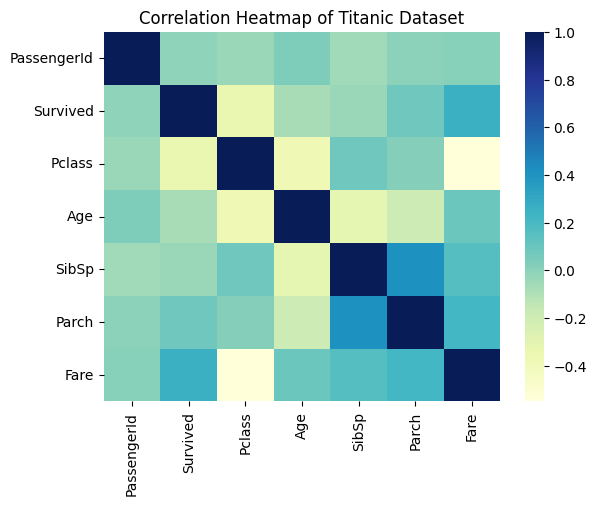

In [7]:
# Plotting only int or float columns correlations
numeric_df = train_data.select_dtypes(include=["int64", "float64"])
sns.heatmap(numeric_df.corr(), cmap='YlGnBu')
plt.title('Correlation Heatmap of Titanic Dataset')
plt.show()

#### Splitting our train set via stratified shuffle split from _sklearn_

Now we want to split our _train_data_ into train and test sets, but with preserved class proportions. 

- We shuffle our dataset randomly via **StratifiedShuffleSplit** from _sklearn_
- Then we split it into train and test sets (80%/20%)
- WHile preserving the distribution of different target variables in both sets (Survived, Pclass, Sex)

This is important when the class is imbalanced like in this case, where the survival rate is low. 


In [8]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits = 1, test_size=0.2, random_state=42)
for train_indeces, test_indeces in split.split(train_data, train_data[["Survived", "Pclass", "Sex"]]):
    strat_train_set = train_data.loc[train_indeces]
    strat_test_set = train_data.loc[test_indeces]

We plot each distirbution across the two sets, in order to verify that they are actually equal across each different variable. 

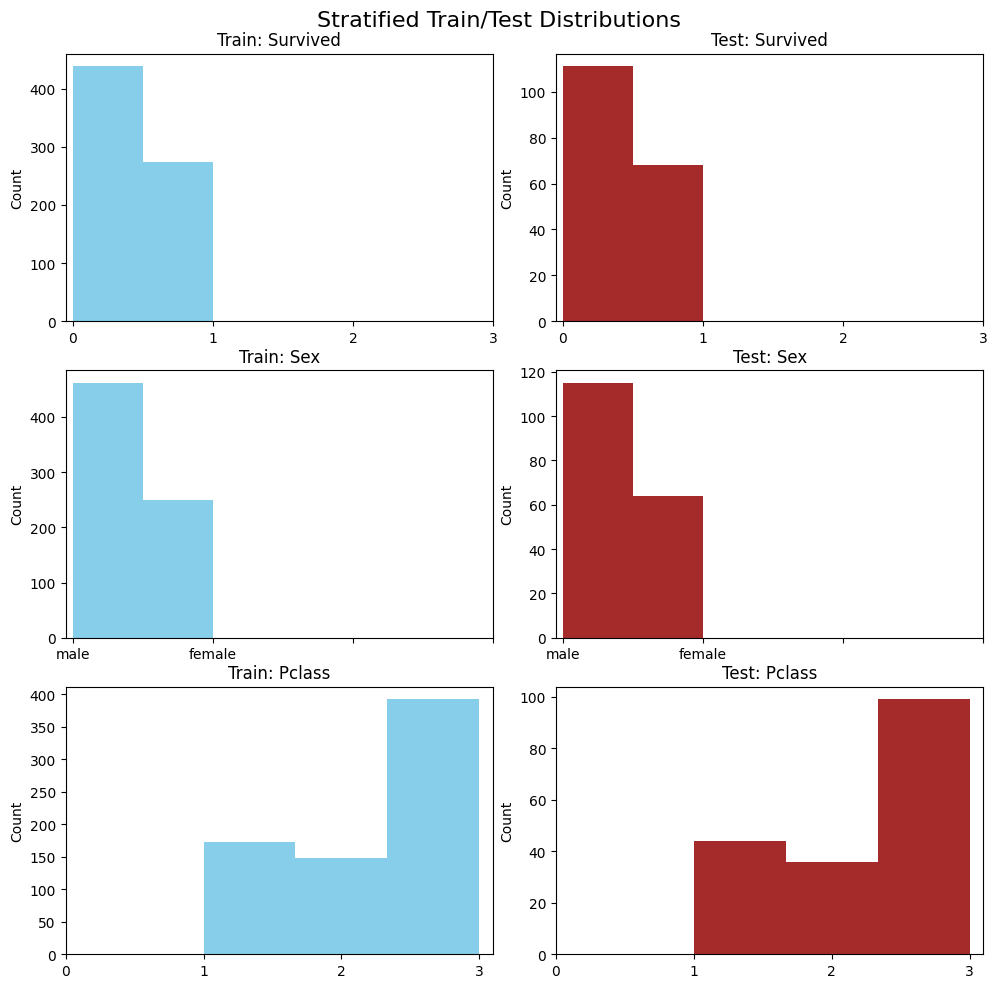

In [9]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 2, figsize=(10, 10))
fig.suptitle("Stratified Train/Test Distributions", fontsize=16)

# Row 1: Survived
axes[0, 0].hist(strat_train_set["Survived"], bins=2, color="skyblue")
axes[0, 0].set_title("Train: Survived")
axes[0, 1].hist(strat_test_set["Survived"], bins=2, color="brown")
axes[0, 1].set_title("Test: Survived")

# Row 2: Sex
axes[1, 0].hist(strat_train_set["Sex"], bins=2, color="skyblue")
axes[1, 0].set_title("Train: Sex")
axes[1, 1].hist(strat_test_set["Sex"], bins=2, color="brown")
axes[1, 1].set_title("Test: Sex")

# Row 3: Pclass
axes[2, 0].hist(strat_train_set["Pclass"], bins=3, color="skyblue")
axes[2, 0].set_title("Train: Pclass")
axes[2, 1].hist(strat_test_set["Pclass"], bins=3, color="brown")
axes[2, 1].set_title("Test: Pclass")

# Clean up
for ax in axes.flat:
    ax.set_xticks([0, 1, 2, 3])
    ax.set_xlabel("")
    ax.set_ylabel("Count")

plt.tight_layout(pad = 0.8, h_pad= 0.2, w_pad= 0.2)
plt.show()

In [10]:
strat_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 867 to 802
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Survived     712 non-null    int64  
 2   Pclass       712 non-null    int64  
 3   Name         712 non-null    object 
 4   Sex          712 non-null    object 
 5   Age          565 non-null    float64
 6   SibSp        712 non-null    int64  
 7   Parch        712 non-null    int64  
 8   Ticket       712 non-null    object 
 9   Fare         712 non-null    float64
 10  Cabin        167 non-null    object 
 11  Embarked     710 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 72.3+ KB


### Feature Engineering 

For first, we need to fill the gaps in the Age column. 
Then, we will have to drop the name column, which is a string, not brining any value to our feature space. Then, we will also transform our '**Sex**' column into a binary variable (0: Male - 1: Female). 

We will also drop '**Cabin**' column and transform into integers the values from the '**Embarked**' column 

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder


class AgeImputer(BaseEstimator, TransformerMixin):
    """Custom transformer to fill missing values in the 'Age' column of the Titanic dataset.
    This transformer uses the mean strategy for imputation.
    """

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        """Impute missing values in the 'Age' column with the mean of the column."""
        X = X.copy()
        imputer = SimpleImputer(strategy='mean')
        X.loc[:, 'Age'] = imputer.fit_transform(X[['Age']]).ravel()
        return X
    
class FeatureEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
        self.columns = None
        self.features_to_encode = ["Embarked", "Sex"]

    def fit(self, X, y=None):
        self.encoder.fit(X[self.features_to_encode])
        self.columns = self.encoder.get_feature_names_out(self.features_to_encode)
        return self

    def transform(self, X):
        X = X.copy()
        encoded = self.encoder.fit_transform(X[self.features_to_encode])
        encoded_df = pd.DataFrame(encoded, columns=self.columns, index=X.index)
        X = X.drop(columns=self.features_to_encode)
        X = pd.concat([X, encoded_df], axis=1)
        return X

class FeatureSelector(BaseEstimator, TransformerMixin):
    """Custom transformer to select specific features from the Titanic dataset.
    This transformer drops the 'Name', 'Ticket', and 'Cabin' columns.
    """

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        """Select specific features from the dataset."""
        X = X.copy()
        columns_to_drop = ['Name', 'Ticket', 'Cabin']
        X = X.drop(columns=columns_to_drop)
        return X

In [12]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('age_imputer', AgeImputer()), 
    ('feature_selector', FeatureSelector()), 
    ('feature_encoder', FeatureEncoder())
])
# Apply the pipeline to the training set
strat_train_set = pipeline.fit_transform(strat_train_set)


ValueError: Shape of passed values is (712, 1), indices imply (712, 6)

In [20]:
strat_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 438 to 871
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Survived     712 non-null    int64  
 2   Pclass       712 non-null    int64  
 3   Sex          712 non-null    int64  
 4   Age          712 non-null    float64
 5   SibSp        712 non-null    int64  
 6   Parch        712 non-null    int64  
 7   Ticket       712 non-null    object 
 8   Fare         712 non-null    float64
 9   Embarked     710 non-null    float64
dtypes: float64(3), int64(6), object(1)
memory usage: 61.2+ KB
